# 1. Perkenalan

Nama    : Dwi Bagus Praetyo

Batch   : FTDS RMT-027

Objective : phising adalah upaya untuk mendapatkan informasi data seseorang dengan teknik pengelabuan/ penipuan. phising biasanya dilakukan dengan mengirimkan sebuah link website ke email seseorang agar pelaku mendapatkan informasi pribari dari orang yang telah mengklik link tersebut. Untuk itulah diperlukan model untuk mengetahui apakah sebuah email termasuk kedalam email phishing atau tidak agar dapat mencegah seseorang kehilangan data pribadi digitalnya

# 2. Import Library

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk

#EDA
from wordcloud import WordCloud

#preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer



# modeling
import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import TextVectorization, Embedding

from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 3. Data Loading

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# load dataset into dataframe
df = pd.read_csv('/content/drive/MyDrive/Phishing_Email.csv')

#drop column Unamed:0 because its index
df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [10]:
df.tail()

,Email Text,Email Type
18645,date a lonely housewife always wanted to date ...,Phishing Email
18646,request submitted : access request for anita ....,Safe Email
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,press clippings - letter on californian utilit...,Safe Email
18649,empty,Phishing Email


# 4. Exploratory Data Analysis (EDA)

In [11]:
df_eda = df.copy()

### Analisis Deskriptif

**Total len word per row**

In [12]:
# count len email text
df_eda['text_length'] = df_eda['Email Text'].apply(lambda x: len(str(x).split(' ')))

In [13]:
df_eda.head()

,Email Text,Email Type,text_length
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,230
1,the other side of * galicismos * * galicismo *...,Safe Email,91
2,re : equistar deal tickets are you still avail...,Safe Email,305
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,146
4,software at incredibly low prices ( 86 % lower...,Phishing Email,91


In [14]:
df_eda.describe()

,text_length
count,1.865000e+04
mean,5.424841e+02
std,2.584164e+04
min,1.000000e+00
25%,7.300000e+01
50%,1.630000e+02
75%,3.630000e+02
max,3.527576e+06


**Information Dataset**

In [15]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Email Text   18634 non-null  object
 1   Email Type   18650 non-null  object
 2   text_length  18650 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


**Check Dimension dataset**

In [16]:
df_eda.shape

(18650, 3)

**Check Missing Value**

In [17]:
df_eda.isnull().sum()

Email Text     16
Email Type      0
text_length     0
dtype: int64

Terdapat data yang missing pada kolom Email Text

In [18]:
df_eda[df_eda['Email Text'].isnull()]

,Email Text,Email Type,text_length
31,NaN,Phishing Email,1
387,NaN,Phishing Email,1
1883,NaN,Phishing Email,1
2049,NaN,Phishing Email,1
2451,NaN,Phishing Email,1
2972,NaN,Phishing Email,1
3627,NaN,Phishing Email,1
3806,NaN,Phishing Email,1
5763,NaN,Phishing Email,1
6299,NaN,Phishing Email,1


Jika kita lihat semua Email Text yang null bertipe phising email, maka kita drop missing value

In [19]:
# drop data yang null/ missing
df_eda.dropna(inplace=True)

**Check Duplicated Data**

In [20]:
cek_dupe = pd.DataFrame()
cek_dupe['Duplikasi'] = df_eda.duplicated()
cek_dupe[cek_dupe['Duplikasi']==True]

,Duplikasi
130,True
244,True
305,True
335,True
378,True
...,...
18607,True
18626,True
18637,True
18643,True


Terdapat 1096 baris yang merupakan data duplikate, selanjut nya bisa kita drop untuk data duplikat nya

Insight:
1. Rata rata jumlah kata pada dataset adalah 542 kata dengan nilai minimumnya 1 kata dan maximumnya 3527576 kata
2. data terdiri dari 2 kolom yang bertipe object
3. dataset memiliki 18650 baris dan 2 kolom
4. Terdapat 16 missing value pada kolom Email Text, selanjutnya bisa kita drop
5. Terdapat 1096 data yang duplicated, selanjutnya bisa kita lakukan drop pada data yang duplikat

### Data Visualization

**Safe vs Phishing Email**

In [21]:
df_eda['Email Type'].value_counts(normalize=True)

Safe Email        0.607599
Phishing Email    0.392401
Name: Email Type, dtype: float64

Text(0.5, 1.0, 'Perbandingaan Antar Booking Status')

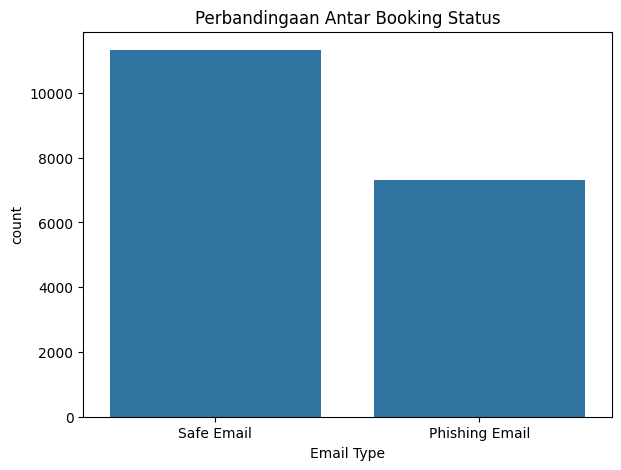

In [22]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.countplot(x=df_eda['Email Type'])
plt.title('Perbandingaan Antar Booking Status')

Data yang kita miliki lebih banyak merupakan Safe Email dibanding Phishing Email

**Word Cloud All Data**

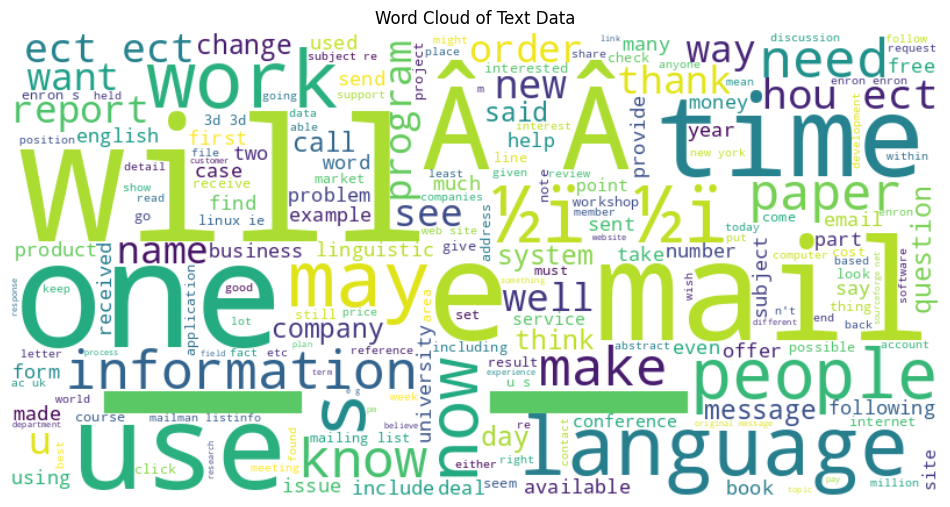

In [23]:
# Join all teks to one string
all_text = ' '.join(df_eda['Email Text'])

#Create Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Show word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

Pada all data kata yang paling banyak ada adalah will, e-mail, time, use, one

**Word Cloud Class Safe Email**

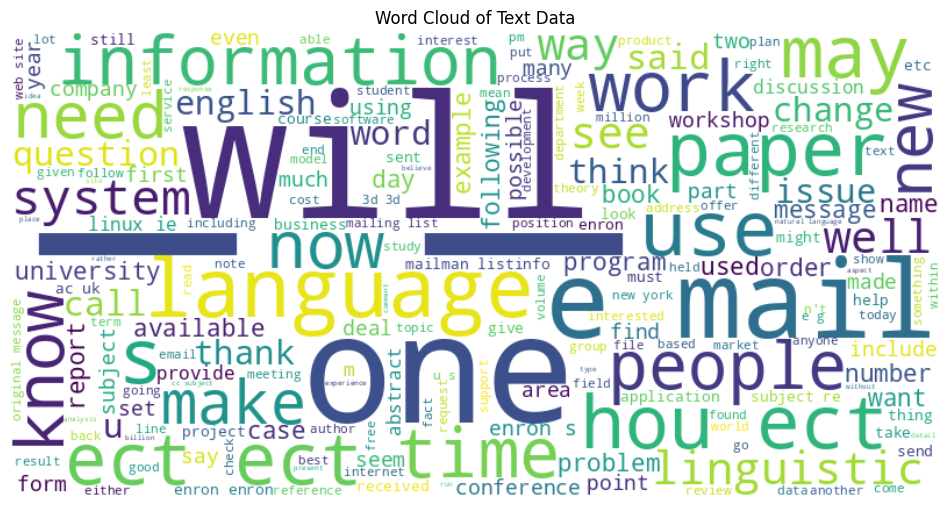

In [24]:
# Join all teks to one string
safe_email = ' '.join(df_eda['Email Text'][df_eda['Email Type']=='Safe Email'])

#Create Word Cloud
wordcloud_safe_email = WordCloud(width=800, height=400, background_color='white').generate(safe_email)

# Show word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_safe_email, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

Pada class Safe Email kata yang paling banyak digunakan adalah will, one, email, language, paper, hou, ect dll

**Word Cloud Class Phishing Email**

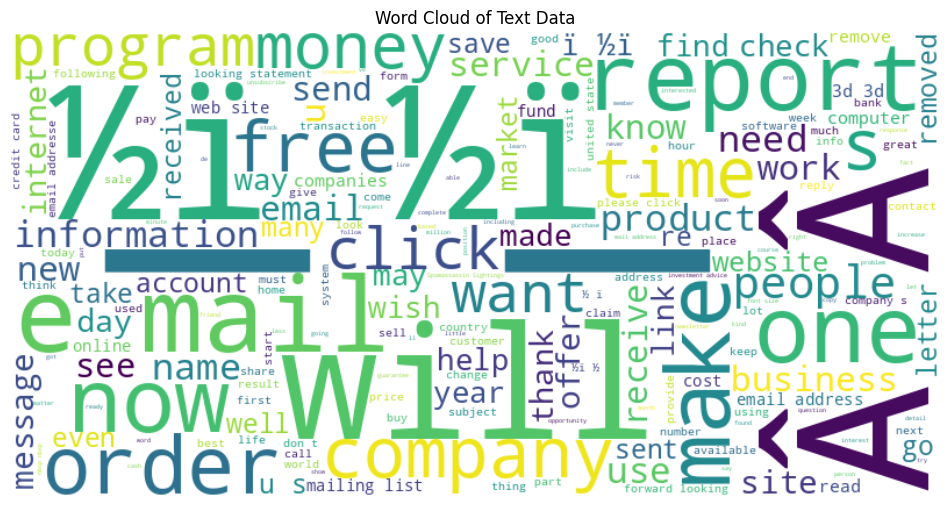

In [25]:
# Join all teks to one string
phishing_email = ' '.join(df_eda['Email Text'][df_eda['Email Type']=='Phishing Email'])

#Create Word Cloud
wordcloud_phishing_email = WordCloud(width=800, height=400, background_color='white').generate(phishing_email)

# Show word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_phishing_email, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

Pada class phishing kata yang sering muncul adalah email, will, one, report, now, money dan beberapa symbol

Insight :
1. Data yang kita miliki lebih banyak merupakan Safe Email dibanding Phishing Email dengan perbandingan 61:39
2. Pada all data kata yang paling banyak ada adalah will, e-mail, time, use, one
3. Pada class Safe Email kata yang paling banyak digunakan adalah will, one, email, language, paper, hou, ect dll
4. Pada class phishing kata yang paling banyak digunakan adalah email, will, one, report, now, money dan beberapa symbol

# 5. Featuring Engineering

## Handle Missing value

In [26]:
# Check missing value
df.isnull().sum()

Email Text    16
Email Type     0
dtype: int64

In [27]:
# drop data yang null/ missing
df.dropna(inplace=True)

## Handle Duplicated

In [28]:
cek_dupe = pd.DataFrame()
cek_dupe['Duplikasi'] = df.duplicated()
cek_dupe[cek_dupe['Duplikasi']==True]

,Duplikasi
130,True
244,True
305,True
335,True
378,True
...,...
18607,True
18626,True
18637,True
18643,True


In [29]:
# Drop data duplicated
df = df.drop_duplicates(keep='first')

## Preprocessing data

### Text Preprocessing

In [30]:
# Define Stopword
stpwds_en = list(set(stopwords.words('english')))

# Define lemmatizer
lemmatizer = WordNetLemmatizer()

In [31]:
# Create A Function for Text Preprocessing

def text_preprocessing(teks):
    # Case folding
    teks = teks.lower()

    # replace n't to not
    teks = teks.replace("n't", 'not')

    # URL removal
    teks = re.sub(r"http\S+", " ", teks)
    teks = re.sub(r"www.\S+", " ", teks)

    # Email Removal
    teks = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", teks)

    # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
    teks = re.sub("[^A-Za-z\s']", " ", teks)

    # remove punctuation
    teks = teks.translate(str.maketrans("", "", string.punctuation))

    # Newline removal (\n)
    teks = re.sub(r"\n", " ",teks)

    # tab removal (\t)
    teks = re.sub(r"\t", " ",teks)

    # remove whitespaces
    teks = teks.strip()

    # remove single letter
    teks = re.sub("\s+", " ", re.sub(r"((?<=^)|(?<= )).((?=$)|(?= ))", '', teks).strip())

    # Tokenization
    tokens = nltk.word_tokenize(teks)

    # Stopwords removal
    tokens = [word for word in tokens if word not in stpwds_en]

    # Lemmatizer
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Combining Tokens
    teks = ' '.join(tokens)

    return teks

In [32]:
# Applying Text Preprocessing to the Dataset

df['text_processed'] = df['Email Text'].apply(lambda x: text_preprocessing(x))
df

,Email Text,Email Type,text_processed
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism sex lang dick hudson ob...
1,the other side of * galicismos * * galicismo *...,Safe Email,side galicismos galicismo spanish term name im...
2,re : equistar deal tickets are you still avail...,Safe Email,equistar deal ticket still available assist ro...
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,hello hot lil horny toy one dream open minded ...
4,software at incredibly low prices ( 86 % lower...,Phishing Email,software incredibly low price lower drapery se...
...,...,...,...
18644,\nRick Moen a Ã©crit:> > I'm confused. I thou...,Safe Email,rick moen crit im confused thought gpled money...
18645,date a lonely housewife always wanted to date ...,Phishing Email,date lonely housewife always wanted date lonel...
18646,request submitted : access request for anita ....,Safe Email,request submitted access request anita dupont ...
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email,important prc mtg hi dorn john discovered rece...


In [33]:
df['text_processed'].iloc[6]

'sun aug wintermute mentioned impression get reading lkml odd time ide gone downhill since andre hedrick effectively removed maintainer martin dalecki seems unable development without much breakage hmm begs question remove handrick ainot broke donot fix see ide subsystem like one ring kludginess due support hundred dodgy chipsets drive mean inherintly evil month looking code turn sour year looking turn arsehole havenot found hobbit code mortal human suffice kate irish linux user group un subscription information list maintainer'

### Target Conversion

In [34]:
# Display Target

df['Email Type'].unique()

array(['Safe Email', 'Phishing Email'], dtype=object)

In [35]:
# Change Target into Number

df['label'] = df['Email Type'].replace({'Safe Email' : 0, 'Phishing Email' : 1})
df

,Email Text,Email Type,text_processed,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism sex lang dick hudson ob...,0
1,the other side of * galicismos * * galicismo *...,Safe Email,side galicismos galicismo spanish term name im...,0
2,re : equistar deal tickets are you still avail...,Safe Email,equistar deal ticket still available assist ro...,0
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,hello hot lil horny toy one dream open minded ...,1
4,software at incredibly low prices ( 86 % lower...,Phishing Email,software incredibly low price lower drapery se...,1
...,...,...,...,...
18644,\nRick Moen a Ã©crit:> > I'm confused. I thou...,Safe Email,rick moen crit im confused thought gpled money...,0
18645,date a lonely housewife always wanted to date ...,Phishing Email,date lonely housewife always wanted date lonel...,1
18646,request submitted : access request for anita ....,Safe Email,request submitted access request anita dupont ...,0
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email,important prc mtg hi dorn john discovered rece...,0


In [36]:
# Target Distribution

df['label'].value_counts()

0    10980
1     6558
Name: label, dtype: int64

### EDA after preprocess

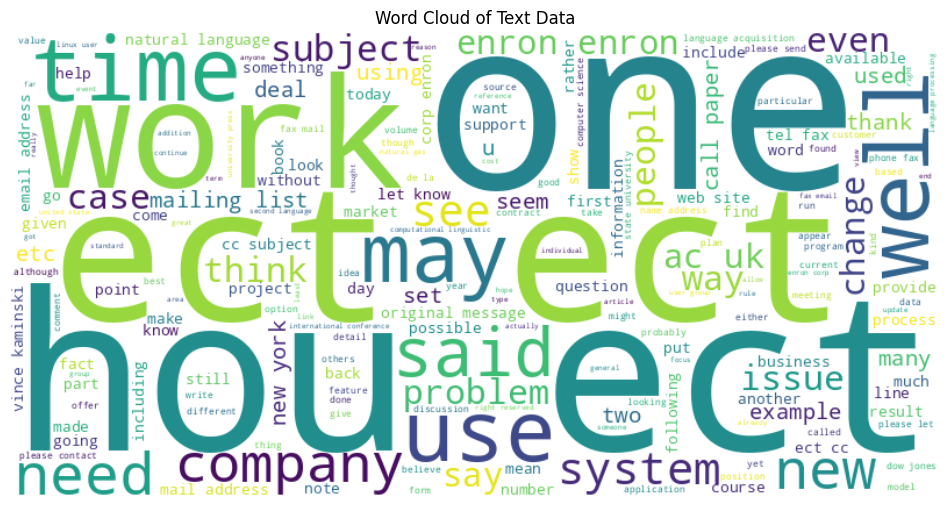

In [37]:
# Join all teks to one string
safe_email = ' '.join(df['text_processed'][df['label']==0])

#Create Word Cloud
wordcloud_safe_email = WordCloud(width=800, height=400, background_color='white').generate(safe_email)

# Show word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_safe_email, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

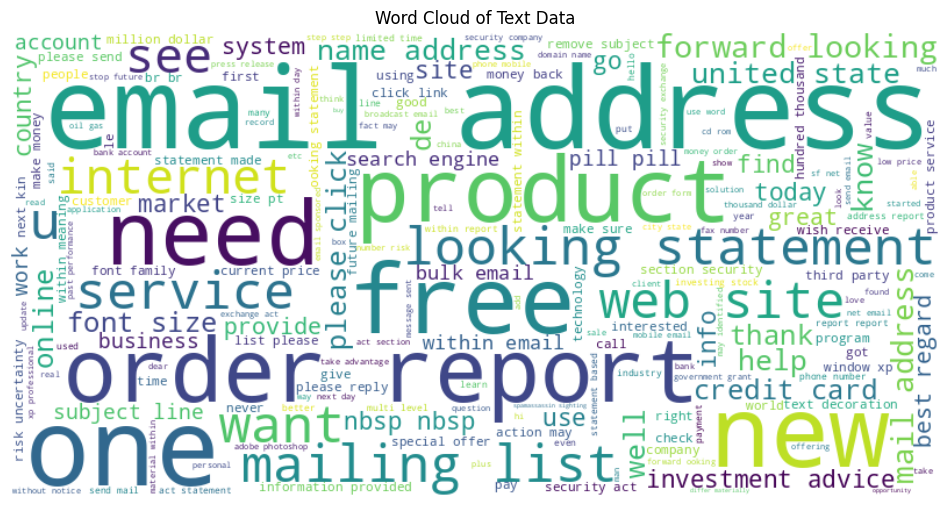

In [38]:
# Join all teks to one string
phishing_email = ' '.join(df['text_processed'][df['label']==1])

#Create Word Cloud
wordcloud_phishing_email = WordCloud(width=800, height=400, background_color='white').generate(phishing_email)

# Show word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_phishing_email, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

Insight:
Pada teks class safe email dan phishing terlihat sudah tidak ada karakter symbol

## Split between `X` (Features) and `y` (Target)

feature kita hanya teks email dan target type email maka kita gunakan teks email yang sudah dipreprocess sebagai feture dan tipe email yang sudah kita encode menjadi target

In [39]:
X = df['text_processed']
y = df['label']

## Split between Train-Set, Val-Set and Test-Set

In [40]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (13416,)
Val Size   :  (1491,)
Test Size  :  (2631,)


## Text Vectorization

In [41]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<13416x119959 sparse matrix of type '<class 'numpy.int64'>'
	with 1387119 stored elements in Compressed Sparse Row format>

In [42]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  119959
Maximum Sentence Length :  15108 tokens


In [43]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [44]:
# Example Result

## Document example
print('Document example')
print(df.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df.text_processed[0]]))
print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)

Document example
disc uniformitarianism sex lang dick hudson observation u use aughter vocative thought provoking sure fair attribute son treated like senior relative one thing normally use brother way aughter hard imagine natural class comprising senior relative excluding brother another seem difference imagining distinction seems senior relative term used wider variety context calling distance get someone attention hence beginning utterance whereas seems natural utterance like yes son hand son one like son son help although perhaps latter one completely impossible alexis mr

Result of Text Vectorization
tf.Tensor([[ 3361 21084   898 ...     0     0     0]], shape=(1, 15108), dtype=int64)
Vector size :  (1, 15108)


In [45]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'enron',
 'ect',
 'one',
 'company',
 'com',
 'please',
 'new',
 'information',
 'time',
 'would',
 'mail',
 'email',
 'get',
 'language',
 'list',
 'may',
 'business',
 'university']

## Word Embedding

In [46]:
# Embedding

embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [47]:
# Example Result

## Document example
print('Document example')
print(df.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df.text_processed[0]]))
print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df.text_processed[0]])).shape)

Document example
disc uniformitarianism sex lang dick hudson observation u use aughter vocative thought provoking sure fair attribute son treated like senior relative one thing normally use brother way aughter hard imagine natural class comprising senior relative excluding brother another seem difference imagining distinction seems senior relative term used wider variety context calling distance get someone attention hence beginning utterance whereas seems natural utterance like yes son hand son one like son son help although perhaps latter one completely impossible alexis mr

Result of  Text Vectorization
tf.Tensor([[ 3361 21084   898 ...     0     0     0]], shape=(1, 15108), dtype=int64)
Vector size :  (1, 15108)

Result of  Embedding
tf.Tensor(
[[[-0.02235432 -0.04996733 -0.00647758 ...  0.04076072 -0.03644364
    0.03457377]
  [-0.01388351 -0.00499935 -0.0102677  ... -0.01937004  0.02189008
   -0.0025396 ]
  [-0.0353501   0.03712377 -0.03588257 ... -0.03869713  0.02024767
    0.02

# 6. ANN Training

## 6.1 Model Definition

In [48]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(1, activation='softmax'))

model_lstm_1.compile(loss='BinaryCrossentropy', optimizer='adam', metrics='accuracy')

Model dibuat dengan sequential api menggunakan 2 hidden layer yang masing - masing hidden layer terdiri dari 32 dan 16 neuron serta 1 output layer menggunakan activation softmax.
untuk parameter loss yang dipakai adalah binarycrosssesntropy karena target berupa binery classification, optimizer yang dipakai adam dan untuk metric menggunakan accuracy

## 6.2 Model Training

In [49]:
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
420/420 [==============================] - 607s 1s/step - loss: 0.1647 - accuracy: 0.3739 - val_loss: 0.0810 - val_accuracy: 0.3742
Epoch 2/5
420/420 [==============================] - 595s 1s/step - loss: 0.0213 - accuracy: 0.3739 - val_loss: 0.0698 - val_accuracy: 0.3742
Epoch 3/5
420/420 [==============================] - 618s 1s/step - loss: 0.0083 - accuracy: 0.3739 - val_loss: 0.0839 - val_accuracy: 0.3742
Epoch 4/5
420/420 [==============================] - 607s 1s/step - loss: 0.0048 - accuracy: 0.3739 - val_loss: 0.0877 - val_accuracy: 0.3742
Epoch 5/5
420/420 [==============================] - 580s 1s/step - loss: 0.0044 - accuracy: 0.3739 - val_loss: 0.1046 - val_accuracy: 0.3742


## 6.3 Model Evaluation

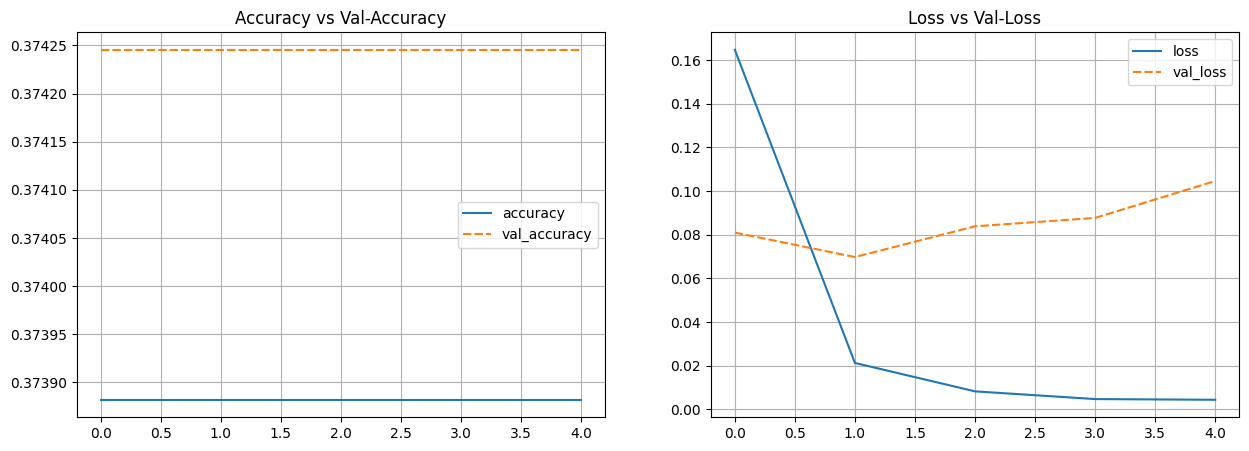

In [52]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

insight :
1. Pada model terlihat tidak ada perubahan pada nilai accuracy antar data train dengan data validasi
2. dari nilai loss nya juga terjadi exploding gradient untuk data validasi

sehingga bisa disimpulkan model under fit

# 7. ANN Improvment

## 7.1 Model Definition

In [60]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_improve = Sequential()
model_improve.add(text_vectorization)
model_improve.add(embedding)
model_improve.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_improve.add(Dropout(0.1))
model_improve.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_improve.add(Dropout(0.1))
model_improve.add(Dense(1, activation='sigmoid'))

model_improve.compile(loss='BinaryCrossentropy', optimizer='adam', metrics='accuracy')

Pada bagian improvment activation pada model diubah menjadi sigmoid

## 7.2 Model Training

In [61]:
model_improve_hist = model_improve.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
420/420 [==============================] - 615s 1s/step - loss: 0.0497 - accuracy: 0.9964 - val_loss: 0.0879 - val_accuracy: 0.9799
Epoch 2/5
420/420 [==============================] - 670s 2s/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.0947 - val_accuracy: 0.9799
Epoch 3/5
420/420 [==============================] - 649s 2s/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1057 - val_accuracy: 0.9805
Epoch 4/5
420/420 [==============================] - 633s 2s/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1163 - val_accuracy: 0.9792
Epoch 5/5
420/420 [==============================] - 587s 1s/step - loss: 4.5254e-04 - accuracy: 0.9999 - val_loss: 0.1440 - val_accuracy: 0.9738


## 7.3 Model Evaluation

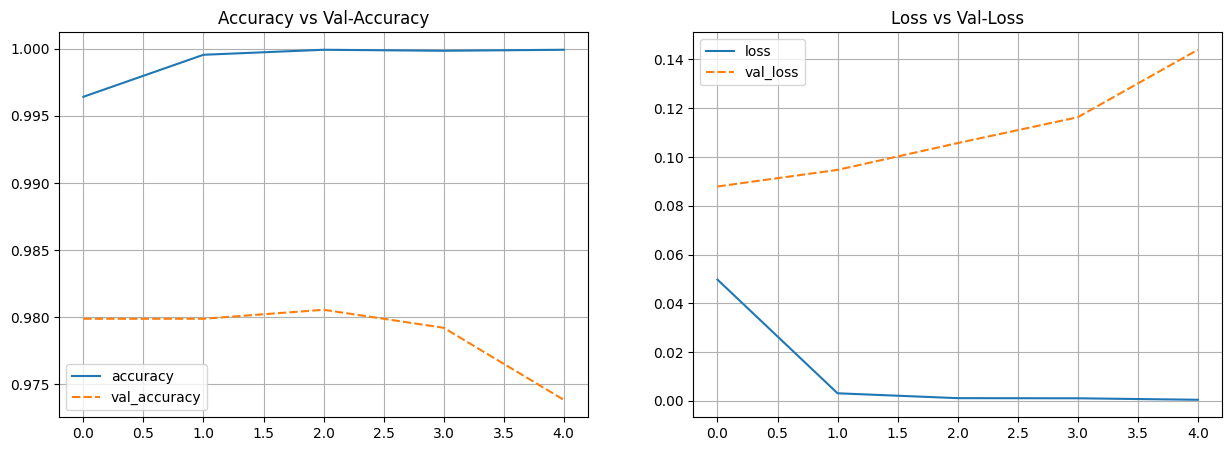

In [64]:
# Plot Training Results

model_improve_hist_df = pd.DataFrame(model_improve_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_improve_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_improve_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

- dari hasil improvment mengalami peningkatan dari segi accuracy dan loss pada data train accuracy mendekati 1 dan pada data validation accuracy di 0.97
- dari segi loss, untuk data train loss nya mendekati 0 dan untuk data validation nilai lossnya berada di 0.14

Model sudah goodfit untuk memprediksi mana email yang safe dan mana yang merupakan email phishing

In [63]:
model_improve.predict(X_test)

83/83 [==============================] - 50s 582ms/step


array([[9.9995768e-01],
       [9.9995565e-01],
       [9.9995935e-01],
       ...,
       [9.9995530e-01],
       [9.9996185e-01],
       [1.5698565e-04]], dtype=float32)

# 8. Model Saving

In [65]:
# Save the Files

import pickle

In [66]:
# Model summary

model_improve.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 15108)             0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15108, 128)        15354752  
                                                                 
 bidirectional (Bidirection  (None, 15108, 64)         41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 15108, 64)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                        

In [67]:
# Freeze model

model_improve.trainable = False
model_improve.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 15108)             0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15108, 128)        15354752  
                                                                 
 bidirectional (Bidirection  (None, 15108, 64)         41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 15108, 64)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                        

In [69]:
# Save ANN model

model_improve.save('titanic_model', save_format='tf')

# 9. Model Inference

## Inisiasi data inference kedalam dataframe

In [72]:
data_inf ={'Email Text' : 'Congratulation You got 8 million dollar please click link below http://dapetdollar.com'
                    }
df_inf = pd.DataFrame([data_inf])
df_inf

,Email Text
0,Congratulation You got 8 million dollar please...


## Preprocesing Inference

In [73]:
df_inf = df_inf['Email Text'].apply(lambda x: text_preprocessing(x))
df_inf

0    congratulation got million dollar please click...
Name: Email Text, dtype: object

## Predict data inference

In [74]:
model_improve.predict(df_inf)

1/1 [==============================] - 1s 830ms/step


array([[0.9998809]], dtype=float32)

data inference di prediksi sebagai email phishing

# 10. Pengambilan Kesimpulan

Pada permodelan sebelum improvment berdasarkan hasil train nya model cenderung underfit.
Setelah dilakukan improvment dengan mengubah activation model menjadi sigmoid model sudah goodfit hanya saja prose pada ephoc yang terlalu sedikit memungkin kan model kurang bisa memprediksi data yang lebih variant. Mungkin bisa ditambahkan lagi epoch untuk proses training model agar model tidak bias